# TDEsAsciiMetric


This notebook demonstrates how to use TDEsAsciiMetric which calculate what fraction of an input TDE lightcurve would be detected. Paired with a spatial slicer, you can obtain the skymap or the observed light curve. 


In [34]:
import os
import numpy as np
import matplotlib.pylab as plt
%matplotlib inline

import healpy as hp
import pandas as pd

import lsst.sims.maf.metrics as metrics
import lsst.sims.maf.slicers as slicers
import lsst.sims.maf.metricBundles as metricBundles
import lsst.sims.maf.db as db
import lsst.sims.maf.plots as plots

from lsst.utils import getPackageDir

In [3]:
# import metric from mafContrib
from mafContrib import TDEsAsciiMetric

## Simulated TDE light curve and the minimum requirement

The TDEsAsciiMetric provides some prameters to meet the requirement of detection TDEs.

- nObsTotal: Required total number of observations in each band.
- nObsPrePeak: Required Number of observations before peak.
- nObsNearPeak: Required number of observations in each band near peak.
- nFiltersNearPeak: Required number of filters near peak.
- nObsPostPeak: Required number of observations after peak.
- nFiltersPostPeak: Required number of number of filters after peak.

**Minimum requirement for detection TDEs** proposed by [Sjoert van Velzen](https://github.com/sjoertvv)

- one detection before peak in any band to make sure we can roughly resolve the time/flux at peak,  set nObsPrePeak=1;
- detections in three different bands within 10 days of peak to measure the color at peak, set nFiltersNearPeak=3, and nearPeakT=10;
- detections at least two bands post peak within two weeks to measure the change of color, set nFiltersPostPeak=2, and postPeakT=14.


```
Parameters according to input lightcurve template and minimum requirement

| parameters | value | meaning| 
| ---        | ---   |
| epochStart | -22   |  Start epoch of input light curve |
| peakEpoch  | 0     |  Peak epoch of input light curve  |
| nearPeakT  | 10    |  Within 10 days around peakEpoch are considered as near peak |
| postPeakT  | 14    |  Within two weeks after peakEpoch are considered as post peak |
| nPhaseCheck| 1     |  Number of phases, 1 means only check the same phase as in ascii file |
| nObsTotal  |{'u': 0, ...}| Number of total observations in each band |
| nObsPrePeak| 1     | Number of observations before peak |
|nObsNearPeak |{'u': 0, ...}| Number of observations in each band |
|nFiltersNearPeak | 3 | Number of filters near peak |
|nObsPostPeak | 0 | Number of observations after peak |
|nFiltersPostPeak | 2 | Number of filters after peak | 
```

The lightcurve template is stored in an ascii file [TDEfaintfast_z0.1.dat](https://github.com/lsst_nonproject/sims_maf_contrib/data/tde/TDEfaintfast_z0.1.dat).

In [4]:
# light curve file
asciifile = os.path.join(getPackageDir('sims_maf_contrib'), 'data', 'tde', 'TDEfaintfast_z0.1.dat')

# query columns 
mjdCol = 'observationStartMJD'
m5Col = 'fiveSigmaDepth'
filterCol = 'filter'
detectSNR={'u': 5, 'g': 5, 'r': 5, 'i': 5, 'z': 5, 'y': 5}

# light curve parameters
epochStart = -22
peakEpoch = 0
nearPeakT = 10
postPeakT = 14 # two weeks
nPhaseCheck = 1

# condition parameters
nObsTotal = {'u': 0, 'g': 0, 'r': 0, 'i': 0, 'z': 0, 'y': 0}
nObsPrePeak = 1
nObsNearPeak = {'u': 0, 'g': 0, 'r': 0, 'i': 0, 'z': 0, 'y': 0}
nFiltersNearPeak = 3
nObsPostPeak = 0 
nFiltersPostPeak = 2

Let's plot the light curve template. 

In [7]:
# plot light curve
def plotlc(dataSlice, time_key='time', mag_key='mag', filter_key='filter', err_key = None,
          peakEpoch=None, nearPeakT=None, postPeakT=None):
    # Input: dataSlice, pandas DataFrame or numpy ndarray
    
    colors = {'u':'k', 'g':'b', 'r':'r', 'i':'m', 'z':'orange', 'y':'c'}
    
    plt.figure(figsize=(10, 6))
    for f in np.unique(dataSlice[filter_key]):
        fmatch = dataSlice[filter_key]==f
        time = dataSlice[time_key][fmatch]
        mag = dataSlice[mag_key][fmatch]
        
        # draw a vertical line to denote pre/near/post peak
        if peakEpoch!=None:
            plt.axvline(x=peakEpoch, linestyle='-', linewidth=1)
            plt.axvline(x=peakEpoch-nearPeakT/2, linestyle='--', linewidth=1)
            plt.axvline(x=peakEpoch+nearPeakT/2, linestyle='--', linewidth=1)
            plt.axvline(x=peakEpoch+nearPeakT/2+postPeakT, linestyle='--', linewidth=1)
        
        if err_key!=None:
            mag_err = dataSlice[err_key][fmatch]
            plt.errorbar(time, mag, yerr=mag_err, color=colors[f], fmt='.', label=f)
        else:
            plt.scatter(time, mag, color=colors[f], marker='*', label=f)

    plt.legend()
    plt.xlabel('days')
    plt.ylabel('mag')
    plt.ylim(plt.ylim()[::-1])

Text(0.5, 0, 'epoch [days] \n An example of an input lightcurve template. \n')

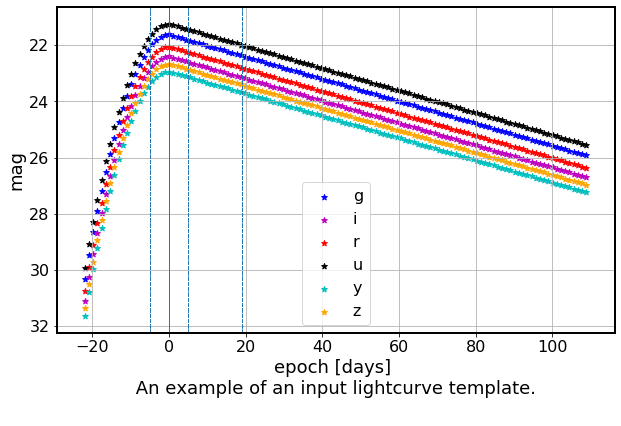

In [9]:
asciifile = '../../data/tde/TDEfaintfast_z0.1.dat'

lcv_template = np.genfromtxt(asciifile, dtype=[('ph', 'f8'), ('mag', 'f8'), ('flt', 'U1')])

df = pd.DataFrame()
df['ph'] = lcv_template['ph']
df['mag'] = lcv_template['mag']
df['flt'] = lcv_template['flt']

plotlc(df, time_key='ph', mag_key='mag', filter_key='flt', 
       peakEpoch=peakEpoch, nearPeakT=nearPeakT, postPeakT=postPeakT)

plt.xlabel('epoch [days] \n An example of an input lightcurve template. \n' )

## Opsim database

Connect to opsim database and get the proposalId

In [12]:
# connect to opsim database
opsdb_baseline = db.OpsimDatabase('baseline_2snapsv1.4_10yrs.db')
opsdb_baseline.fetchPropInfo()

({0: 'Other',
  1: 'WFD',
  2: 'DD:XMM-LSS',
  3: 'DD:ECDFS',
  4: 'DD:290',
  5: 'DD:ELAISS1',
  6: 'DD:COSMOS'},
 {'WFD': [1], 'DD': [2, 3, 4, 5, 6], 'NES': []})

In [13]:
# output directory
outDir = 'TDE_example'
resultsDb = db.ResultsDb(outDir=outDir)

### get skymap

In [16]:
# Calculate the metric over the sky. 
tde_metric = TDEsAsciiMetric(asciifile=None, mjdCol=mjdCol, m5Col=m5Col, filterCol=filterCol, 
                              detectSNR=detectSNR, epochStart=epochStart, peakEpoch=peakEpoch, 
                              nearPeakT=nearPeakT, postPeakT=postPeakT, nPhaseCheck=nPhaseCheck,
                              nObsTotal= nObsTotal, nObsPrePeak=nObsPrePeak, 
                              nObsNearPeak=nObsNearPeak, nFiltersNearPeak=nFiltersNearPeak, 
                              nObsPostPeak=nObsPostPeak, nFiltersPostPeak=nFiltersPostPeak,
                              dataout=False)

slicer = slicers.HealpixSlicer(nside=32) 
sqlconstraint = 'note not like "%DD%"'  # exclude DD visits

tde_sky = metricBundles.MetricBundle(tde_metric, slicer, sqlconstraint, metadata='NonDD', runName='Baseline')

group = metricBundles.MetricBundleGroup({'tde_sky': tde_sky}, opsdb_baseline, 
                                        outDir=outDir, resultsDb=resultsDb)
group.runAll()

Healpix slicer using NSIDE=32, approximate resolution 109.935565 arcminutes
Querying database SummaryAllProps with constraint note not like "%DD%" for columns ['observationStartMJD', 'fieldDec', 'fieldRA', 'filter', 'fiveSigmaDepth']
Found 1826046 visits
Running:  ['tde_sky']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.


Plotting figures with "note not like "%DD%"" constraint now.


/Users/lynnej/lsst_stack/stack/miniconda3-4.7.12-984c9f7/DarwinX86/healpy/1.10.3.lsst2+5/lib/python/healpy-1.10.3-py3.7-macosx-10.9-x86_64.egg/healpy/projaxes.py:1027: MatplotlibDeprecationWarning: 
The iterable function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use np.iterable instead.
  if matplotlib.cbook.iterable(value):
/Users/lynnej/lsst_stack/stack/miniconda3-4.7.12-984c9f7/DarwinX86/healpy/1.10.3.lsst2+5/lib/python/healpy-1.10.3-py3.7-macosx-10.9-x86_64.egg/healpy/projaxes.py:1027: MatplotlibDeprecationWarning: 
The iterable function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use np.iterable instead.
  if matplotlib.cbook.iterable(value):
/Users/lynnej/lsst_stack/stack/miniconda3-4.7.12-984c9f7/DarwinX86/healpy/1.10.3.lsst2+5/lib/python/healpy-1.10.3-py3.7-macosx-10.9-x86_64.egg/healpy/projaxes.py:1027: MatplotlibDeprecationWarning: 
The iterable function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use np.iterable instead.
 

monopole: 0.0317573  dipole: lon: -162.276, lat: -75.6402, amp: 0.0187765
Plotting complete.


/Users/lynnej/lsst_stack/stack/miniconda3-4.7.12-984c9f7/DarwinX86/healpy/1.10.3.lsst2+5/lib/python/healpy-1.10.3-py3.7-macosx-10.9-x86_64.egg/healpy/projaxes.py:1027: MatplotlibDeprecationWarning: 
The iterable function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use np.iterable instead.
  if matplotlib.cbook.iterable(value):


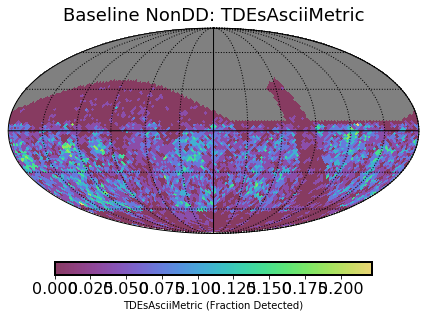

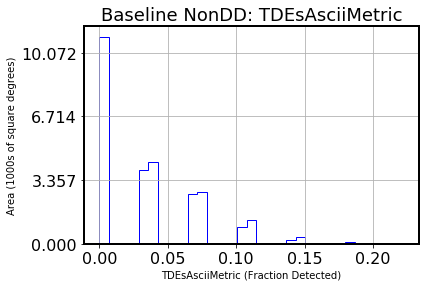

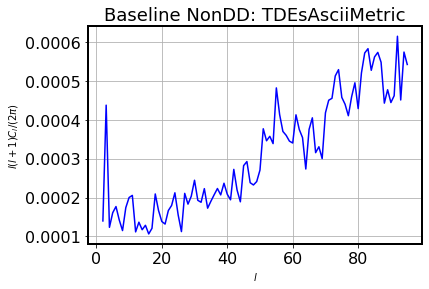

In [18]:
group.plotAll(closefigs=False)

Note that the sky map metric information was already saved to disk - and we can easily read it back.

In [21]:
!ls $outDir

Baseline_TDEsAsciiMetric_NonDD_HEAL.npz
Baseline_TDEsAsciiMetric_NonDD_HEAL_Histogram.pdf
Baseline_TDEsAsciiMetric_NonDD_HEAL_PowerSpectrum.pdf
Baseline_TDEsAsciiMetric_NonDD_HEAL_SkyMap.pdf
resultsDb_sqlite.db
thumb.Baseline_TDEsAsciiMetric_NonDD_HEAL_Histogram.png
thumb.Baseline_TDEsAsciiMetric_NonDD_HEAL_PowerSpectrum.png
thumb.Baseline_TDEsAsciiMetric_NonDD_HEAL_SkyMap.png


Healpix slicer using NSIDE=32, approximate resolution 109.935565 arcminutes
[-- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- --]


{'SkyMap': 1}

/Users/lynnej/lsst_stack/stack/miniconda3-4.7.12-984c9f7/DarwinX86/healpy/1.10.3.lsst2+5/lib/python/healpy-1.10.3-py3.7-macosx-10.9-x86_64.egg/healpy/projaxes.py:1027: MatplotlibDeprecationWarning: 
The iterable function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use np.iterable instead.
  if matplotlib.cbook.iterable(value):


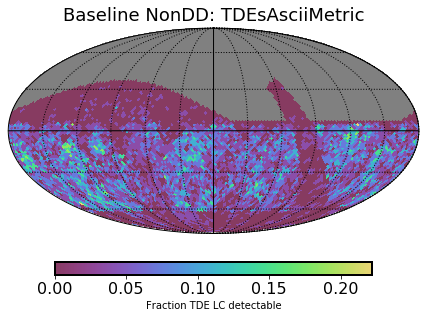

In [32]:
saved = metricBundles.createEmptyMetricBundle()
saved.read(os.path.join(outDir, 'Baseline_TDEsAsciiMetric_NonDD_HEAL.npz'))
print(saved.metricValues[0:20])
saved.setPlotDict({'nTicks': 5, 'xlabel': 'Fraction TDE LC detectable'})
saved.plot(plotFunc=plots.HealpixSkyMap())

### get light curve 

In [33]:
## get light curve for a particular point on the sky by set dataout=True and use UserPointSlicer()
tde_metric2 = TDEsAsciiMetric(asciifile=asciifile, mjdCol=mjdCol, m5Col=m5Col, filterCol=filterCol, detectSNR=detectSNR,
                 epochStart=epochStart, peakEpoch=peakEpoch, nearPeakT=nearPeakT, nPhaseCheck=nPhaseCheck,
                 nObsTotal= nObsTotal,nObsPrePeak=nObsPrePeak, 
                 nObsNearPeak=nObsNearPeak, nFiltersNearPeak=nFiltersNearPeak, 
                 nObsPostPeak=nObsPostPeak, nFiltersPostPeak=nFiltersPostPeak,
                 dataout=True)
# ra,dec of ipix 
ra = np.array([255.9375])
dec = np.array([0.0])
slicer = slicers.UserPointsSlicer(ra, dec)

sqlconstraint = 'night<730 and proposalId=1'
tde_sky2 = metricBundles.MetricBundle(tde_metric2, slicer, sqlconstraint, runName='baseline')

group = metricBundles.MetricBundleGroup({'tde2': tde_sky2}, opsdb_baseline, 
                                        outDir=outDir, resultsDb=resultsDb)
group.runAll()

Querying database SummaryAllProps with constraint night<730 and proposalId=1 for columns ['observationStartMJD', 'fieldDec', 'fieldRA', 'filter', 'fiveSigmaDepth']
Found 301825 visits
Running:  ['tde2']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.


The output metricValues is a list of dictionaries for each phase(tshift). Each dictionary contains arrays of 

|  variable   |  meaning   |
| --- | --- |
| 'tshift' | the phase shift of the light curve|
| 'timeMJD' | the time column |
| 'm5'     | the fiveSigmaDepth |
|'filters' | filters |
| 'lcNumber'| number of light curve|
|'lcEpoch' | epoch of the light curve |
| 'prePeakCheck' | equals True for prePeak observations |
| 'nearPeakCheck'| equals True for nearPeak observations|
| 'postPeakCheck'| equals True for postPeak observations|
| 'lcMags'| magnitudes of the light curve|
| 'lcSNR' | signal to noise ratio|
| 'lcMagsStd'| standard deviation of magnitudes|
| 'lcAboveThresh'| equals True if for detected magnitudes|
| 'detected' |equals True if this light curve was detected|

In [39]:
len(tde_sky2.metricValues.data)

1

In [42]:
# save file and plot light curve
output_dict_list = tde_sky2.metricValues.data[0]
df = pd.DataFrame(output_dict_list[0])

df.to_csv(os.path.join(outDir, 'baseline.csv'), index=False)

df.head()

,tshift,timeMJD,m5,filters,lcNumber,lcEpoch,prePeakCheck,nearPeakCheck,postPeakCheck,lcMags,lcSNR,lcMagsStd,lcAboveThresh,detected
0,0.0,59987.371378,21.732515,y,0.0,-22.000000,True,False,False,31.620000,0.000555,8.140662,False,False
1,0.0,59987.375429,21.623997,y,0.0,-21.995949,True,False,False,31.616907,0.000503,8.246031,False,False
2,0.0,60000.369677,21.864083,y,0.0,-9.001702,True,False,False,24.396011,0.485511,1.214193,False,False
3,0.0,60000.373733,21.865954,y,0.0,-8.997645,True,False,False,24.394684,0.486943,1.212041,False,False
4,0.0,60000.379636,21.976803,y,0.0,-8.991742,True,False,False,24.392752,0.540244,1.137498,False,False


The output light curve can be plotted use the same function defined above.

Text(0.5, 0, 'epoch [days] \n An example of detected light curve.\nIt meets the minimum requirements: one detection before peak,\n three filters near peak, and two filters post peak within two weeks.')

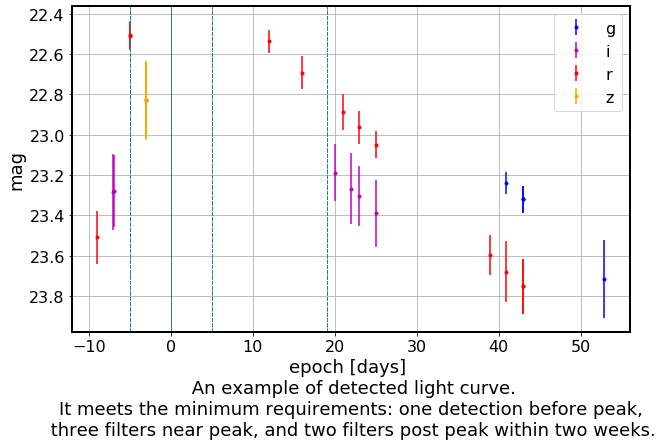

In [45]:
# load from csv
# df = pd.read_csv(os.path.join(outDir, 'baseline.csv'))

# plot all light curve
# plotlc(df[ (df['lcAboveThresh'])], time_key='expMJD', mag_key='lcMags', filter_key='filters', err_key='lcMagsStd')

# plot a specific light curve
plotlc(df[(df['lcAboveThresh']) & (df['lcNumber']==0)], time_key='lcEpoch', 
       mag_key='lcMags', filter_key='filters', err_key='lcMagsStd', 
       peakEpoch=peakEpoch, nearPeakT=nearPeakT, postPeakT=postPeakT)

plt.xlabel('epoch [days] \n An example of detected light curve.\n'\
           'It meets the minimum requirements: one detection before peak,'\
           '\n three filters near peak, and two filters post peak within two weeks.')

Other opsim databases can be explored by following the same procedure.